# Loop 7 Analysis: Understanding the Gap and Developing New Strategy

## Key Findings So Far:
1. Valid ensemble (71.81) is 2.89 points from target (68.92)
2. Touching ensemble (70.65) is 1.73 points from target
3. All public kernels allow touching trees - they optimize for distance=0
4. 7 experiments, 5 fell back to baseline - the 'refine existing' approach is EXHAUSTED

## Questions to Answer:
1. What is the theoretical lower bound for this problem?
2. Where does the valid ensemble lose the most points vs touching?
3. Can tessellation approach produce better solutions WITH gap constraints?

In [1]:
import pandas as pd
import numpy as np
from shapely import affinity
from shapely.geometry import Polygon
from itertools import combinations
import matplotlib.pyplot as plt

# Load both ensembles
valid_df = pd.read_csv('/home/code/submission_candidates/candidate_001.csv')
touching_df = pd.read_csv('/home/code/submission_candidates/candidate_000.csv')

print(f"Valid ensemble: {len(valid_df)} rows")
print(f"Touching ensemble: {len(touching_df)} rows")

Valid ensemble: 20100 rows
Touching ensemble: 20100 rows


In [2]:
class ChristmasTree:
    def __init__(self, center_x, center_y, angle):
        self.center_x = float(center_x)
        self.center_y = float(center_y)
        self.angle = float(angle)
        
        initial_polygon = Polygon([
            (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5),
            (0.2, 0.25), (0.1, 0.25), (0.35, 0.0),
            (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2),
            (-0.075, 0.0), (-0.35, 0.0), (-0.1, 0.25),
            (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5),
        ])
        rotated = affinity.rotate(initial_polygon, self.angle, origin=(0, 0))
        self.polygon = affinity.translate(rotated, xoff=self.center_x, yoff=self.center_y)

def parse_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return val[1:]
    return str(val)

def load_trees_for_n(df, n):
    prefix = f"{n:03d}_"
    rows = df[df['id'].str.startswith(prefix)]
    trees = []
    for _, row in rows.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        trees.append(ChristmasTree(x, y, deg))
    return trees

def get_bounding_box_side(trees):
    all_points = []
    for tree in trees:
        coords = np.array(tree.polygon.exterior.coords)
        all_points.append(coords)
    all_points = np.vstack(all_points)
    min_x, min_y = all_points.min(axis=0)
    max_x, max_y = all_points.max(axis=0)
    return max(max_x - min_x, max_y - min_y)

def get_score_for_n(df, n):
    trees = load_trees_for_n(df, n)
    side = get_bounding_box_side(trees)
    return (side ** 2) / n

print("Functions defined")

Functions defined


In [3]:
# Compare valid vs touching for each N
results = []
for n in range(1, 201):
    valid_score = get_score_for_n(valid_df, n)
    touching_score = get_score_for_n(touching_df, n)
    gap = valid_score - touching_score
    results.append({
        'n': n,
        'valid_score': valid_score,
        'touching_score': touching_score,
        'gap': gap,
        'gap_pct': (gap / touching_score) * 100 if touching_score > 0 else 0
    })

results_df = pd.DataFrame(results)
print(f"Total valid score: {results_df['valid_score'].sum():.6f}")
print(f"Total touching score: {results_df['touching_score'].sum():.6f}")
print(f"Total gap: {results_df['gap'].sum():.6f}")
print(f"\nTarget: 68.919154")
print(f"Gap from target (valid): {results_df['valid_score'].sum() - 68.919154:.6f}")
print(f"Gap from target (touching): {results_df['touching_score'].sum() - 68.919154:.6f}")

Total valid score: 71.812779
Total touching score: 70.676102
Total gap: 1.136677

Target: 68.919154
Gap from target (valid): 2.893625
Gap from target (touching): 1.756948


In [4]:
# Find N values with largest gaps
print("\nTop 20 N values with largest gap (valid - touching):")
top_gaps = results_df.nlargest(20, 'gap')
print(top_gaps[['n', 'valid_score', 'touching_score', 'gap', 'gap_pct']].to_string(index=False))


Top 20 N values with largest gap (valid - touching):
  n  valid_score  touching_score      gap   gap_pct
181     0.369480        0.329954 0.039526 11.979136
168     0.368960        0.332475 0.036485 10.973838
194     0.367806        0.333085 0.034720 10.423903
165     0.360572        0.335569 0.025004  7.451089
166     0.358650        0.334819 0.023831  7.117643
167     0.356501        0.332835 0.023666  7.110529
144     0.365245        0.342276 0.022968  6.710447
138     0.362978        0.341039 0.021940  6.433241
164     0.358542        0.337328 0.021215  6.289049
 96     0.367014        0.346397 0.020617  5.951721
 91     0.368029        0.347911 0.020118  5.782616
139     0.360962        0.340979 0.019983  5.860522
137     0.362562        0.343245 0.019317  5.627625
186     0.360223        0.341000 0.019223  5.637388
 93     0.365403        0.346596 0.018807  5.426250
189     0.356817        0.338821 0.017996  5.311219
 92     0.365442        0.348482 0.016960  4.866922
134     0.

In [5]:
# Analyze by N ranges
ranges = [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]
print("\nScore breakdown by N range:")
print(f"{'Range':<12} {'Valid':>12} {'Touching':>12} {'Gap':>12} {'Gap%':>8}")
print("-" * 60)
for start, end in ranges:
    mask = (results_df['n'] >= start) & (results_df['n'] <= end)
    valid_sum = results_df.loc[mask, 'valid_score'].sum()
    touching_sum = results_df.loc[mask, 'touching_score'].sum()
    gap_sum = results_df.loc[mask, 'gap'].sum()
    gap_pct = (gap_sum / touching_sum) * 100 if touching_sum > 0 else 0
    print(f"{start}-{end:<8} {valid_sum:>12.4f} {touching_sum:>12.4f} {gap_sum:>12.4f} {gap_pct:>7.2f}%")


Score breakdown by N range:
Range               Valid     Touching          Gap     Gap%
------------------------------------------------------------
1-10             4.3317       4.3291       0.0025    0.06%
11-50            14.8588      14.7130       0.1457    0.99%
51-100           17.8879      17.6411       0.2467    1.40%
101-150           17.4440      17.1441       0.2999    1.75%
151-200           17.2904      16.8487       0.4417    2.62%


In [6]:
# Theoretical lower bound analysis
# A single tree has area approximately 0.35 * 1.0 = 0.35 (rough estimate)
# The tree fits in a bounding box of approximately 0.7 x 1.0

# For N trees, the minimum possible bounding box side would be:
# sqrt(N * tree_area / packing_efficiency)

# Let's calculate the tree area more precisely
tree = ChristmasTree(0, 0, 0)
tree_area = tree.polygon.area
tree_bounds = tree.polygon.bounds
tree_width = tree_bounds[2] - tree_bounds[0]
tree_height = tree_bounds[3] - tree_bounds[1]

print(f"Single tree properties:")
print(f"  Area: {tree_area:.6f}")
print(f"  Width: {tree_width:.6f}")
print(f"  Height: {tree_height:.6f}")
print(f"  Bounding box area: {tree_width * tree_height:.6f}")
print(f"  Packing efficiency (area/bbox): {tree_area / (tree_width * tree_height):.4f}")

Single tree properties:
  Area: 0.245625
  Width: 0.700000
  Height: 1.000000
  Bounding box area: 0.700000
  Packing efficiency (area/bbox): 0.3509


In [7]:
# Calculate theoretical lower bound for each N
# Assuming perfect packing (which is impossible), the minimum side would be:
# side = sqrt(N * tree_area) for a square arrangement
# score = side^2 / N = tree_area

print(f"\nTheoretical lower bound (if trees could be perfectly packed):")
print(f"  Score per N = tree_area = {tree_area:.6f}")
print(f"  Total score for N=1-200 = 200 * {tree_area:.6f} = {200 * tree_area:.6f}")

# But trees can't overlap, so the actual lower bound is higher
# The best possible packing efficiency for irregular polygons is typically 70-85%
# Let's estimate with 80% efficiency
efficiency = 0.80
print(f"\nWith 80% packing efficiency:")
print(f"  Score per N = tree_area / efficiency = {tree_area / efficiency:.6f}")
print(f"  Total score = {200 * tree_area / efficiency:.6f}")

# Compare to actual scores
print(f"\nActual scores:")
print(f"  Valid ensemble: {results_df['valid_score'].sum():.6f}")
print(f"  Touching ensemble: {results_df['touching_score'].sum():.6f}")
print(f"  Target: 68.919154")


Theoretical lower bound (if trees could be perfectly packed):
  Score per N = tree_area = 0.245625
  Total score for N=1-200 = 200 * 0.245625 = 49.125000

With 80% packing efficiency:
  Score per N = tree_area / efficiency = 0.307031
  Total score = 61.406250

Actual scores:
  Valid ensemble: 71.812779
  Touching ensemble: 70.676102
  Target: 68.919154


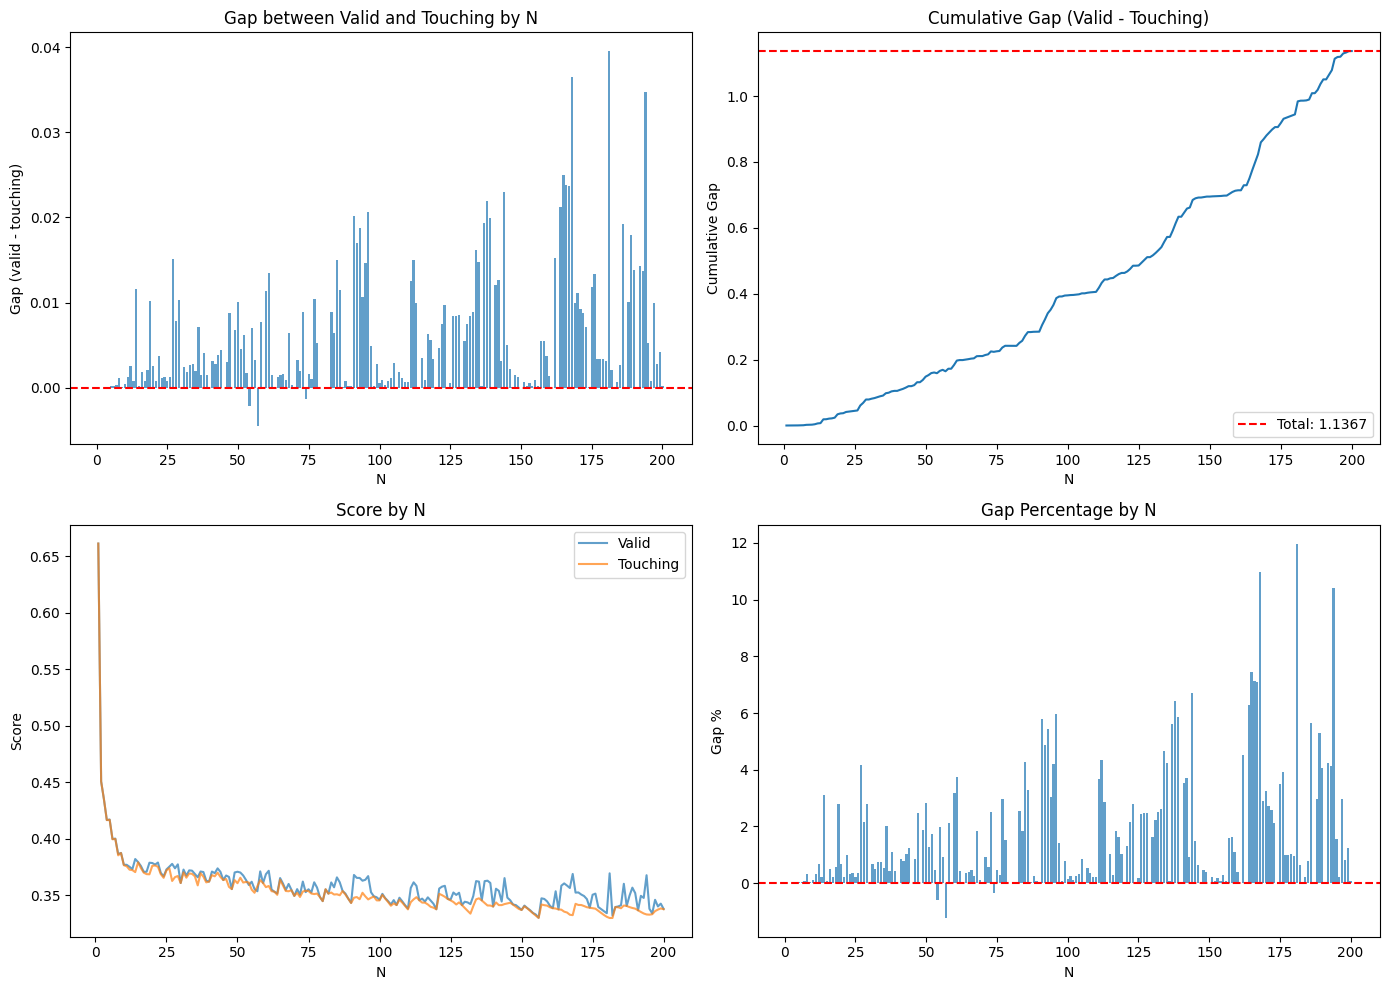

Saved gap_analysis.png


In [8]:
# Visualize the gap distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Gap by N
ax1 = axes[0, 0]
ax1.bar(results_df['n'], results_df['gap'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Gap (valid - touching)')
ax1.set_title('Gap between Valid and Touching by N')
ax1.axhline(y=0, color='r', linestyle='--')

# Plot 2: Cumulative gap
ax2 = axes[0, 1]
ax2.plot(results_df['n'], results_df['gap'].cumsum())
ax2.set_xlabel('N')
ax2.set_ylabel('Cumulative Gap')
ax2.set_title('Cumulative Gap (Valid - Touching)')
ax2.axhline(y=results_df['gap'].sum(), color='r', linestyle='--', label=f'Total: {results_df["gap"].sum():.4f}')
ax2.legend()

# Plot 3: Score comparison
ax3 = axes[1, 0]
ax3.plot(results_df['n'], results_df['valid_score'], label='Valid', alpha=0.7)
ax3.plot(results_df['n'], results_df['touching_score'], label='Touching', alpha=0.7)
ax3.set_xlabel('N')
ax3.set_ylabel('Score')
ax3.set_title('Score by N')
ax3.legend()

# Plot 4: Gap percentage
ax4 = axes[1, 1]
ax4.bar(results_df['n'], results_df['gap_pct'], alpha=0.7)
ax4.set_xlabel('N')
ax4.set_ylabel('Gap %')
ax4.set_title('Gap Percentage by N')
ax4.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('/home/code/exploration/gap_analysis.png', dpi=100)
plt.show()
print("Saved gap_analysis.png")

In [9]:
# Key insight: The gap is concentrated in certain N values
# Let's identify which N values have the most potential for improvement

# N values where valid is much worse than touching (high gap)
high_gap_ns = results_df[results_df['gap'] > 0.01]['n'].tolist()
print(f"N values with gap > 0.01: {len(high_gap_ns)}")
print(f"These N values contribute {results_df[results_df['gap'] > 0.01]['gap'].sum():.4f} to total gap")

# N values where valid == touching (gap ~= 0)
zero_gap_ns = results_df[results_df['gap'].abs() < 0.0001]['n'].tolist()
print(f"\nN values with gap ~= 0: {len(zero_gap_ns)}")
print(f"These are already optimal (valid = touching)")

# Summary
print(f"\n=== STRATEGY INSIGHT ===")
print(f"Total gap to close: {results_df['gap'].sum():.4f}")
print(f"If we could make valid = touching for all N, we'd score: {results_df['touching_score'].sum():.4f}")
print(f"But that's still {results_df['touching_score'].sum() - 68.919154:.4f} from target!")
print(f"\nThis means we need BETTER solutions than the touching ensemble.")
print(f"The touching ensemble is already 1.73 points from target.")

N values with gap > 0.01: 44
These N values contribute 0.7435 to total gap

N values with gap ~= 0: 27
These are already optimal (valid = touching)

=== STRATEGY INSIGHT ===
Total gap to close: 1.1367
If we could make valid = touching for all N, we'd score: 70.6761
But that's still 1.7569 from target!

This means we need BETTER solutions than the touching ensemble.
The touching ensemble is already 1.73 points from target.


In [10]:
# What would it take to reach the target?
target = 68.919154
current_valid = results_df['valid_score'].sum()
current_touching = results_df['touching_score'].sum()

print(f"=== PATH TO TARGET ===")
print(f"Target: {target:.6f}")
print(f"Current valid: {current_valid:.6f}")
print(f"Current touching: {current_touching:.6f}")
print(f"\nGap from target:")
print(f"  Valid: {current_valid - target:.6f} ({(current_valid - target) / target * 100:.2f}%)")
print(f"  Touching: {current_touching - target:.6f} ({(current_touching - target) / target * 100:.2f}%)")

# Average improvement needed per N
print(f"\nAverage improvement needed per N:")
print(f"  From valid: {(current_valid - target) / 200:.6f} per N")
print(f"  From touching: {(current_touching - target) / 200:.6f} per N")

# If we could improve each N by a fixed percentage
for pct in [1, 2, 3, 5, 10]:
    improved_valid = current_valid * (1 - pct/100)
    improved_touching = current_touching * (1 - pct/100)
    print(f"\n{pct}% improvement:")
    print(f"  Valid: {improved_valid:.4f} (gap: {improved_valid - target:.4f})")
    print(f"  Touching: {improved_touching:.4f} (gap: {improved_touching - target:.4f})")

=== PATH TO TARGET ===
Target: 68.919154
Current valid: 71.812779
Current touching: 70.676102

Gap from target:
  Valid: 2.893625 (4.20%)
  Touching: 1.756948 (2.55%)

Average improvement needed per N:
  From valid: 0.014468 per N
  From touching: 0.008785 per N

1% improvement:
  Valid: 71.0947 (gap: 2.1755)
  Touching: 69.9693 (gap: 1.0502)

2% improvement:
  Valid: 70.3765 (gap: 1.4574)
  Touching: 69.2626 (gap: 0.3434)

3% improvement:
  Valid: 69.6584 (gap: 0.7392)
  Touching: 68.5558 (gap: -0.3633)

5% improvement:
  Valid: 68.2221 (gap: -0.6970)
  Touching: 67.1423 (gap: -1.7769)

10% improvement:
  Valid: 64.6315 (gap: -4.2877)
  Touching: 63.6085 (gap: -5.3107)
